In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
from scipy import sparse

from gcn.utils import *



# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_float('learning_rate', 0.004, 'Initial learning rate.')

flags.DEFINE_integer('hidden1', 40, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 100, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden3', 100, 'Number of units in hidden layer 1.')

flags.DEFINE_integer('hidden4', 50, 'Number of units in hidden layer 1.')


flags.DEFINE_integer('hidden5', 30, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden6', 30, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden7', 30, 'Number of units in hidden layer 1.')



flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')



In [2]:
type(FLAGS.hidden6)

int

In [3]:
# Get adjacency matrix
# Get degree matrix
def edges_tuples(filepath,remove_permutations=True):
    neigbors=pd.read_csv(filepath,header=0)
    neigbors=neigbors.sort_index()
    neigbors=neigbors.values
    neigborsTouple=[tuple(l) for l in neigbors]
    del neigbors
    if remove_permutations:
        neigborsTouple_no_permu=set(tuple(sorted(l)) for l in neigborsTouple)
        if len(neigborsTouple_no_permu)==len(neigborsTouple)/2:
            print("Single direction edges were created")
        else:
            print("After removing permutations, dimentions dont match")
        del neigborsTouple
        neigborsTouple_no_permu=sorted(neigborsTouple_no_permu)
        return neigborsTouple_no_permu
    else:
        print("Double direction edges were created")
        return neigborsTouple
    

# This base graph remains the same
def base_node_info(frame0File,neighbors_tuples):
    senders_arr=[]
    receivers_arr=[]
    el_pos=pd.read_csv(frame0File,header=0,usecols=[" Element Label","X","Y","Z"],index_col=" Element Label")
    el_pos=el_pos.values
    el_pos=el_pos*1000
    #el_pos=normalizePos(el_pos,1,-1)
    
    for edge in neighbors_tuples:
        sender=edge[0]-1
        receiver=edge[1]-1
        senders_arr.append(sender)
        receivers_arr.append(receiver)


    return el_pos



def change_training_dir(tr_dirs,send_rec_arr):
       
    path=tr_dirs
    
    in_tr_path=os.listdir(path)
    stress_path=[file for file in in_tr_path if file[-10:]=='stress.csv']
    stress_npz_path=[file for file in in_tr_path if file[-4:]=='.npz']
    global_path=[file for file in in_tr_path if file[:5]=='RNode' ]
    nodes_pos=base_node_info(path+stress_path[0],send_rec_arr)
        # Element features
    
    stress_arr= np.load(path+stress_npz_path[0])
    m_vm_data=stress_arr["peeq"]
    #m_vm_data=np.cbrt(m_vm_data)
    m_status_data= stress_arr["status"]
        # global features file 
    m_tool_info=pd.read_fwf(path+global_path[0],header=1,skiprows=1)
    m_tool_info=m_tool_info.values
    header_pos=0
    while all(np.isnan(m_tool_info[header_pos,...])):
        header_pos+=1

    m_tool_info=m_tool_info[...,1:]
    m_tool_info=m_tool_info[header_pos:header_pos+np.shape(m_vm_data)[1],...] # replace this by the lenght of stresses
    column_index=0
    while (column_index < np.shape(m_tool_info)[1]):
        if all(np.isnan(m_tool_info[...,column_index])):
            m_tool_info=np.delete(m_tool_info, np.s_[column_index], 1)
        else:
            column_index+=1
    m_tool_cf=m_tool_info[...,:3]/200
    
    tool_pos=m_tool_info[...,5:]*1000
    
    m_tool_info=np.append(m_tool_cf,tool_pos,axis=1)

    return m_tool_info,m_vm_data,m_status_data,nodes_pos

def CreateFeaturesFrame(tool_positions,stresses,n_positions,frame_to_predict):    
    vs_in= stresses[...,frame_to_predict-1]
    delta_vs_presente= (-stresses[...,frame_to_predict]+stresses[...,frame_to_predict-1])
    pos_tool_f=tool_positions[frame_to_predict][-3:]
    n_rel_pos=pos_tool_f-n_positions
    feat_mx=np.append(n_rel_pos,np.transpose([vs_in]),axis=-1)
    delta_vs_presente=np.transpose([delta_vs_presente])
    return feat_mx,delta_vs_presente



In [4]:
send_rec_arr= edges_tuples('/home/mara/Documents/gcn/gcn/tinymesh/tinyEleNeighborhood.csv',remove_permutations=False)
#send_rec_arr=np.concatenate( (np.array(send_rec_arr,dtype='int32')), axis=0 ).reshape((len(send_rec_arr), 2))
adj = nx.adjacency_matrix(nx.Graph(send_rec_arr))
support = [preprocess_adj(adj)]
num_supports = 1

tool_info,vm_data,status_data,n_positions= change_training_dir('/home/mara/Documents/gcn/gcn/tinymesh/',send_rec_arr)
initial_pos=[0,0,0,0, -1.13909,  7.67766e-001]
tool_info=initial_pos+tool_info


Double direction edges were created


In [5]:
f=25
features,y_tr=CreateFeaturesFrame(tool_info,vm_data,n_positions,f)
#y_tr=np.transpose([y_tr])
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.placeholder(tf.float32, shape=(None, features.shape[1])),
    'labels': tf.placeholder(tf.float32, shape=(None, y_tr.shape[1])),
}

In [6]:
import gcnModel as gcnmodels
model=gcnmodels.GCN(placeholders, input_dim=np.shape(features)[1], logging=True)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:

def fill_feed_dict(features, support, labels, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    return feed_dict

sess = tf.Session()


# Define model evaluation function FOR VALIDATION
def evaluate(features, support, labels,placeholders):
    t_test = time.time()
    feed_dict_val = fill_feed_dict(features, support, labels,placeholders)
    outs_val , m_out= sess.run([model.loss], model.outputs ,feed_dict=feed_dict_val)
    return outs_val, (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []

In [10]:
# Initialize session


frames_arr=[50,51,52,53,54]

# Train model
for epoch in range(200000):
    random.shuffle(frames_arr)
    loss_epoch=0
    for frame_to_train in frames_arr:
        features,y_tr=CreateFeaturesFrame(tool_info,vm_data,n_positions,frame_to_train)
        t = time.time()
        # Construct feed dictionary
        a_feed_dict = fill_feed_dict(features, support, y_tr, placeholders)
        # Training step
        outs = sess.run([model.opt_op, model.loss, model.predict()], feed_dict=a_feed_dict)
        loss_epoch+= outs[1]

        # Print results
    if epoch%1000==0:
        loss_epoch=loss_epoch/len(frames_arr)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss_epoch), "time=", "{:.5f}".format(time.time() - t))


print("Optimization Finished!")

Epoch: 0001 train_loss= 0.01740 time= 0.04851
Epoch: 1001 train_loss= 0.01658 time= 0.04995
Epoch: 2001 train_loss= 0.01654 time= 0.05885
Epoch: 3001 train_loss= 0.01778 time= 0.05553
Epoch: 4001 train_loss= 0.01733 time= 0.05804
Epoch: 5001 train_loss= 0.01861 time= 0.05539
Epoch: 6001 train_loss= 0.01770 time= 0.05116
Epoch: 7001 train_loss= 0.01726 time= 0.05663
Epoch: 8001 train_loss= 0.01778 time= 0.05763
Epoch: 9001 train_loss= 0.01677 time= 0.05353
Epoch: 10001 train_loss= 0.02030 time= 0.05427
Epoch: 11001 train_loss= 0.01666 time= 0.04999
Epoch: 12001 train_loss= 0.02094 time= 0.05405
Epoch: 13001 train_loss= 0.02277 time= 0.05601
Epoch: 14001 train_loss= 0.01890 time= 0.05227
Epoch: 15001 train_loss= 0.01514 time= 0.05530
Epoch: 16001 train_loss= 0.01921 time= 0.05702


KeyboardInterrupt: 

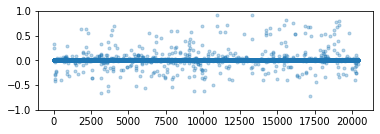

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  

delta=a_feed_dict[placeholders['labels']][...,-1]-outs[-1][...,-1]

ax1 = plt.subplot(211)
deltas_peed=delta[...,0]

plt.ylim(-1,1)
axs1=plt.plot(range(np.shape(delta)[0]), delta,'.',alpha=0.3)


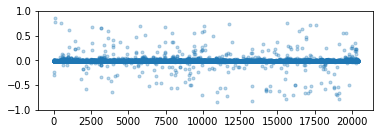

In [11]:

import matplotlib.pyplot as plt
%matplotlib inline  

delta=a_feed_dict[placeholders['labels']][...,-1]-outs[-1][...,-1]

ax1 = plt.subplot(211)
deltas_peed=delta[...,0]

plt.ylim(-1,1)
axs1=plt.plot(range(np.shape(delta)[0]), delta,'.',alpha=0.3)